In [2]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
RETINOTOPY_PATH = "D:/retinotopy/aligned_xy"
DATA_PATH = "Z:/data/PROC"
MODEL_PATH = "C:/Users/labadmin/Documents/models/mouseobj"

In [4]:
oneshot = []
oneshot.append({'mname': 'TX115', 'datexp': '2023_12_04', 'blk':'1'})
oneshot.append({'mname': 'FX26', 'datexp': '2023_12_04', 'blk':'1'})
oneshot.append({'mname': 'TX115', 'datexp': '2023_12_08', 'blk':'1'})
oneshot.append({'mname': 'FX26', 'datexp': '2023_12_08', 'blk':'1'})

In [5]:
def get_interp_speed_v2(m1):
    #compute speed
    df = utils.get_movement_df(m1)
    ntrials = m1.frameselector["trial_no"].astype(int).max()
    speed_interp = np.empty((ntrials, 400))
    #interp speed to 400 positions
    for trial_no in m1.frameselector["trial_no"].unique():
        trial_no = int(trial_no)
        trial_speed = df.query(f"trial == {trial_no}")["pitch"].values * 10
        trial_distance = df.query(f"trial == {trial_no}")["distance"].values
        speed_interp[trial_no-1] = np.interp(np.arange(400), trial_distance, trial_speed)
    return speed_interp

def compute_coding_dirs(m1):
    name, date, blk = m1.name, m1.datexp, m1.blk
    areas = ["V1", "medial", "lateral", "anterior"]
    interp_spks = m1.interp_spks - m1.interp_spks.mean(1, keepdims=True)
    utils.compute_dprime(m1, discrimination_region=(0,125), concatenate=False, remove_mean=False)
    ntrials = m1.interp_spks.shape[1]
    ncells = m1.interp_spks.shape[0]
    planes = 2
    cod_dirs = np.empty((ntrials, len(areas), planes, 400)) #ntrials x areas x plane x positions
    selective_cells = np.empty((4,2,2, ncells))
    main_dir = Path(f"../data/notz/oneshot/{name}/{date}/{blk}")
    if not main_dir.exists():
        main_dir.mkdir(parents=True)
    for indexa, area in enumerate(areas):
        ia = utils.get_region_idx(m1.iarea, area)
        for plane in range(planes):
            selected_plane = (m1._iplane >= 10) if plane == 0 else (m1._iplane < 10)
            pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_plane], tsh=95) #tresh based on the area 
            prefer_r = (m1.train_dp>=pstv_tsh)
            prefer_nr = (m1.train_dp<=ngtv_tsh)
            area_prefer_r = prefer_r * ia * selected_plane
            area_prefer_nr = prefer_nr * ia * selected_plane
            dir_for_type = interp_spks[area_prefer_r] - interp_spks[area_prefer_nr]
            avg_dir = dir_for_type.mean(0)
            cod_dirs[:, indexa, plane, :] = avg_dir
            selective_cells[indexa, plane, 0, :] = area_prefer_r
            selective_cells[indexa, plane, 1, :] = area_prefer_nr
    np.save(main_dir / "cod_dirs_0_125.npy", cod_dirs)
    np.save(main_dir / "selective_cells_0_125.npy", selective_cells)


In [8]:
Mice = []
for sess in oneshot:
    m = utils.load_mouse(sess['mname'], 
                        sess['datexp'], 
                        sess['blk'], 
                        data_path = DATA_PATH,
                        mdl_path = MODEL_PATH,
                        ret_path = RETINOTOPY_PATH,
                        load_neurons=True,
                        interp_behav=True,
                        load_retinotopy=True)
    Mice.append(m)

Checking if model object exists ...
Timeline with fname: Timeline_TX115_2023_12_04_1.mat not found, trying with fname: TX115_2023_12_04_1.mat 
Timeline file is in v7.3 format, loading with h5py
planes: 20


100%|██████████| 20/20 [10:03<00:00, 30.20s/it]


Loading retinotopy data from D:\retinotopy\aligned_xy\TX115_2023_12_04_1_behav.npz
Checking if model object exists ...
Loading mouse object from C:\Users\labadmin\Documents\models\mouseobj\FX26\2023_12_04\1
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'interp_spks'])
Checking if model object exists ...
Loading mouse object from C:\Users\labadmin\Documents\models\mouseobj\TX115\2023_12_08\1
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'interp_spks'])
Checking if model object exists ...
Loading mouse object from C:\Users\lab

In [11]:
Mice[0].frameselector = utils.get_frameselector(Mice[0])

compute coding dirs, speed and lickrates:

In [12]:
for m1 in Mice:
    name, date, blk = m1.name, m1.datexp, m1.blk
    main_dir = Path(f"../data/notz/oneshot/{name}/{date}/{blk}")
    print(f"Processing {name} {date} {blk}")
    m1.interp_spks = utils.interp_spks_by_corridorlength(m1, m1.frameselector, corridor_length=400, z=False)
    print(" now computing coding directions")
    compute_coding_dirs(m1)
    print("getting speed interpolation and lick rates")
    speed_interp = get_interp_speed_v2(m1)
    _, lickrate = utils.get_lick_rates(m1)
    np.save(main_dir / "lickrate.npy", lickrate)
    np.save(main_dir / "speed_interp.npy", speed_interp)
    clear_output(wait=True)
print("Proccessing done")

Proccessing done


In [23]:
for m in Mice:
    m.trial_dict = utils.get_trialno_bytype(m.frameselector)

In [124]:
avgs_coding_dirs = np.zeros((4, 4, 4, 2, 400))
areas = ["V1", "medial", "lateral", "anterior"]
for iss, m in enumerate(Mice):
    name, date, blk, = m.name, m.datexp, m.blk
    pth = Path(fr"..\data\notz\oneshot\{name}\{date}\{blk}\cod_dirs_0_125.npy")
    cod_dirs = np.load(pth)
    for a, _ in enumerate(areas):
        for plane in range(2):
            for i_t, (ttype, trials) in enumerate(m.trial_dict.items()):
                if ttype in ['rewarded','non rewarded']:
                    t = trials[1::2] # only use test trials
                    avgs_coding_dirs[iss, i_t, a, plane, :] = cod_dirs[t, a, plane, :].mean(0)
                else:
                    if np.isnan(trials).all():
                        pass
                    else:
                        avgs_coding_dirs[iss, i_t, a, plane, :] = cod_dirs[trials, a, plane, :].mean(0)
    clear_output(wait=True)
np.save(r"..\data\notz\oneshot\overall\avgs_coding_dirs.npy", avgs_coding_dirs)
print("Done...")
print(avgs_coding_dirs.shape, "session, ttype, area, plane, positions")

Done...
(4, 4, 4, 2, 400) session, ttype, area, plane, positions


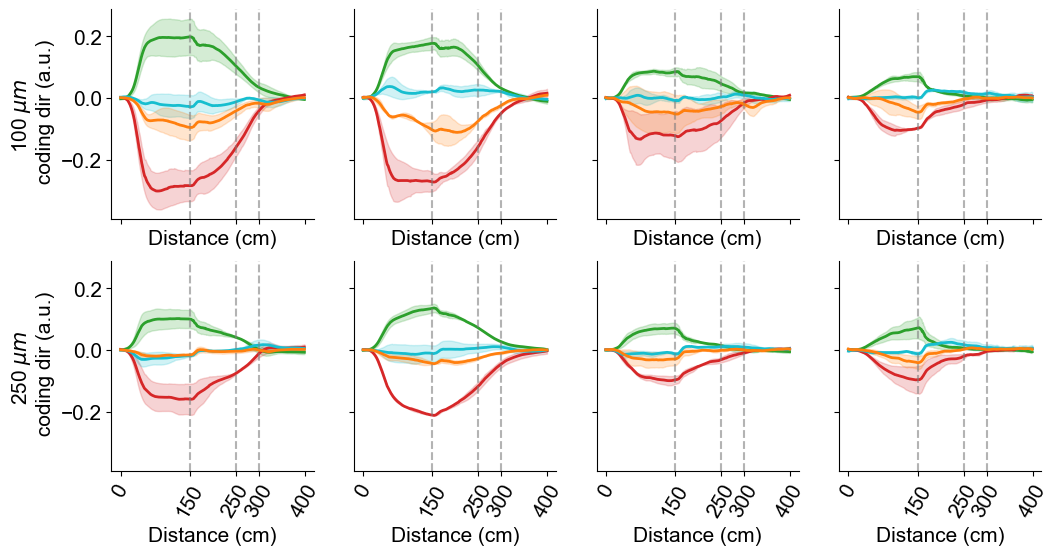

In [141]:
from scipy.stats import sem
first_sess = avgs_coding_dirs[:2]
last_sess = avgs_coding_dirs[2:]
first_sess_mean = np.mean(first_sess, axis=0) #ttype, area, plane, positions
last_sess_mean = np.mean(last_sess, axis=0) #ttype, area, plane, positions
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange'] #rew #nrew #rew_test #nrew_test #GI
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ttype in range(4):
    for a, area in enumerate(areas):
        for l in range(2):
            mean_plot = last_sess_mean[ttype, a, l]
            sem_plot = sem(last_sess[:,ttype, a, l], axis=0)
            ax[l,a].plot(mean_plot, color=trial_type_palette[ttype], linewidth=2)
            ax[l,a].fill_between(np.arange(400), mean_plot - sem_plot, mean_plot + sem_plot, 
                                        color=trial_type_palette[ttype], alpha=0.2)
            ax[l,a].axvline(x=150, color='gray', linestyle='--', alpha=0.2)
            ax[l,a].axvline(x=250, color='gray', linestyle='--', alpha=0.2)
            ax[l,a].axvline(x=300, color='gray', linestyle='--', alpha=0.2)
            ax[l,a].set_xlabel('Distance (cm)')
            ax[l,a].set_xticks([0, 150, 250, 300, 400])
            #rotate xticks
            for tick in ax[l, a].get_xticklabels():
                tick.set_rotation(60)
            if a == 0:
                ltext = "100 $\mu m$" if l == 0 else "250 $\mu m$"
                ax[l,a].set_ylabel(f'{ltext} \n coding dir (a.u.)', color='k')

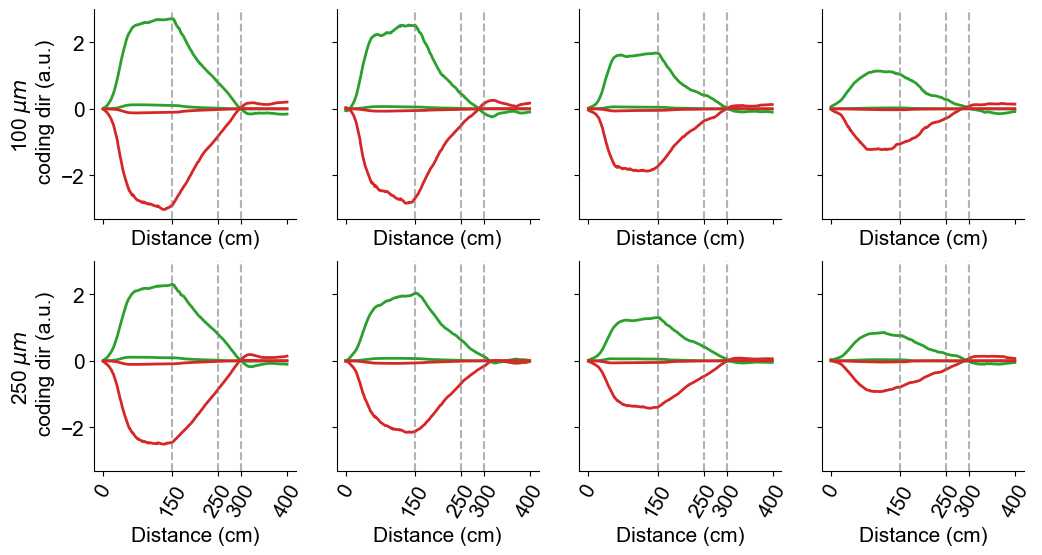

In [145]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for sess in range(first_sess.shape[0]):
    for ttype in range(2):
        for a, area in enumerate(areas):
            for l in range(2):
                ax[l,a].plot(first_sess[sess,ttype, a, l], color=trial_type_palette[ttype], linewidth=2)
                ax[l,a].axvline(x=150, color='gray', linestyle='--', alpha=0.2)
                ax[l,a].axvline(x=250, color='gray', linestyle='--', alpha=0.2)
                ax[l,a].axvline(x=300, color='gray', linestyle='--', alpha=0.2)
                ax[l,a].set_xlabel('Distance (cm)')
                ax[l,a].set_xticks([0, 150, 250, 300, 400])
                #rotate xticks
                for tick in ax[l, a].get_xticklabels():
                    tick.set_rotation(60)
                if a == 0:
                    ltext = "100 $\mu m$" if l == 0 else "250 $\mu m$"
                    ax[l,a].set_ylabel(f'{ltext} \n coding dir (a.u.)', color='k')

In [146]:
gis = np.empty((2,4,2))
for day in range(last_sess.shape[0]):
    cd_selection = last_sess[day,:,:,:,:125]
    cd_selection = cd_selection.mean(-1)
    for plane in range(2):
        for area in range(4):
            cyan_orange = np.abs(cd_selection[2,area, plane] - cd_selection[3, area, plane])
            green_red = np.abs(cd_selection[0,area, plane] - cd_selection[1, area, plane])
            gis[day, area, plane] = cyan_orange/green_red

Text(0.1, 0.8, '250 $\\mu m$')

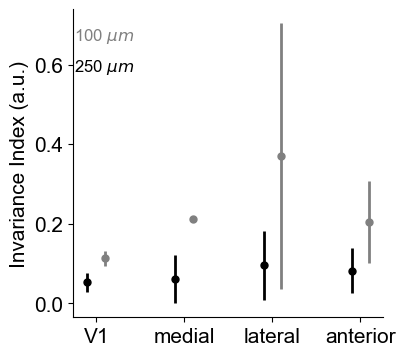

In [161]:
gis_mean = gis.mean(0)
gis_sem = sem(gis, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)
for a, area in enumerate(areas):
    for plane in range(2):
        c = 'gray' if plane == 0 else 'black'
        off = 0.1 if plane == 0 else -0.1
        ax.errorbar(x=a+off, y=gis_mean[a, plane], yerr=gis_sem[a, plane], linewidth=2, marker='o', markersize=5, color=c)
ax.set_xticks(np.arange(4), labels=areas)
ax.set_ylabel('Invariance Index (a.u.)')
ax.text(.1, 0.9, '100 $\mu m$', color='gray', fontsize=12, ha='center', transform=ax.transAxes)
ax.text(.1, 0.8, '250 $\mu m$', color='black', fontsize=12, ha='center', transform=ax.transAxes)


In [77]:
def build_correct_dicts(m, lick_window=(150,250), onlytest=False):
    """
    Build dictionaries of correct and incorrect trials for each trial type.
    """
    correct_dict = {}
    incorrect_dict = {}
    for ttype in ["rewarded", "non rewarded", "rewarded test", "non rewarded test"]:
        t_licks, t_nolicks = utils.get_trials_with_licks(m, lick_window=lick_window, trialtype=ttype, onlytest=onlytest)
        if ttype in ["rewarded", "rewarded test"]:
            correct_dict[ttype] = t_licks
            incorrect_dict[ttype] = t_nolicks
        if ttype in ["non rewarded", "non rewarded test"]:
            correct_dict[ttype] = t_nolicks
            incorrect_dict[ttype] = t_licks
    return correct_dict, incorrect_dict

def plot_catvsbehav(behav_cov, ylabel, ax, legend=False):
    cat_a = behav_cov[:,0]
    cat_b = behav_cov[:,1]
    ax.plot(cat_a.mean(0), color='tab:green', linestyle='-', label='Category A')
    ax.fill_between(np.arange(400), cat_a.mean(0)-sem(cat_a, axis=0), cat_a.mean(0)+sem(cat_a, axis=0), alpha=0.3, color='tab:green')
    ax.plot(cat_b.mean(0), color='tab:red', linestyle='-', label='Category B')
    ax.fill_between(np.arange(400), cat_b.mean(0)-sem(cat_b, axis=0), cat_b.mean(0)+sem(cat_b, axis=0), alpha=0.3, color='tab:red')
    ax.set_ylabel(ylabel)
    ax.set_xticks([0, 150, 250, 300, 400], ['0', '150', '250', '300', '400'], rotation=45)    
    for i in range(2):
        if legend:
            ax.legend(bbox_to_anchor=(1.05, .9), fontsize=15, frameon=False)
        ax.set_xlabel("Position (cm)")
        ax.axvline(150, color='k', linestyle='--', alpha=0.5)
        ax.axvline(250, color='k', linestyle='--', alpha=0.5)
        ax.axvline(300, color='k', linestyle='--', alpha=0.5)

In [93]:
avg_speed_cat_lick = np.empty((2, 2, 2, 400)) # animals, trial types, lick/no lick, 400 positions
avg_lrate_cat_lick = np.empty((2, 2, 2, 400)) # animals, trial types, lick/no lick, 400 positions
avg_arrays = [avg_speed_cat_lick, avg_lrate_cat_lick]
for iss, m in enumerate([Mice[2],Mice[3]]):
    print(iss, m)
    name, date, blk = m.name, m.datexp, m.blk
    speed = np.load(Path(f"../data/notz/oneshot/{name}/{date}/{blk}/speed_interp.npy"))
    lrate = np.load(Path(f"../data/notz/oneshot/{name}/{date}/{blk}/lickrate.npy"))
    features = [speed, lrate]
    m.trial_dict = utils.get_trialno_bytype(m.frameselector)
    correct_dict, incorrect_dict = build_correct_dicts(m, lick_window=(150,250), onlytest=False) 
    correct_A = np.concatenate([correct_dict["rewarded"], correct_dict["rewarded test"]])
    correct_B = np.concatenate([correct_dict["non rewarded"], correct_dict["non rewarded test"]])
    incorrect_A = np.concatenate([incorrect_dict["rewarded"], incorrect_dict["rewarded test"]])
    incorrect_B = np.concatenate([incorrect_dict["non rewarded"], incorrect_dict["non rewarded test"]])
    correct_trials = [correct_A, correct_B]
    incorrect_trials = [incorrect_A, incorrect_B]
    for i in range(2):
        for i_f, feature in enumerate(features):
            feature_c = np.mean(feature[correct_trials[i]], axis=0)
            feature_inc = np.mean(feature[incorrect_trials[i]], axis=0)
            avg_arrays[i_f][iss, i, 0] = feature_c
            avg_arrays[i_f][iss, i, 1] = feature_inc
    clear_output(wait=True)
np.save("../data/notz/oneshot/overall/avg_speed_cat_lick.npy", avg_arrays[0])
np.save("../data/notz/oneshot/overall/avg_lrate_cat_lick.npy", avg_arrays[1])
print("Done...")

Done...


In [163]:
avg_speed_cat = np.empty((2, 2, 400)) # animals, trial types, lick/no lick, 400 positions
avg_lrate_cat = np.empty((2, 2, 400)) # animals, trial types, lick/no lick, 400 positions
avg_arrays = [avg_speed_cat, avg_lrate_cat]
for iss, m in enumerate([Mice[2],Mice[3]]):
    name, date, blk = m.name, m.datexp, m.blk
    speed = np.load(Path(f"../data/notz/oneshot/{name}/{date}/{blk}/speed_interp.npy"))
    lrate = np.load(Path(f"../data/notz/oneshot/{name}/{date}/{blk}/lickrate.npy"))
    features = [speed, lrate]
    cat_A = np.concatenate([m.trial_dict['rewarded'], m.trial_dict['rewarded test']])
    cat_B = np.concatenate([m.trial_dict['non rewarded'], m.trial_dict['non rewarded test']])
    trial_cats = [cat_A, cat_B]
    for i_f, feature in enumerate(features):
        for it, trials in enumerate(trial_cats):
            feature_mean = np.mean(feature[trials], axis=0)
            avg_arrays[i_f][iss, it] = feature_mean
    clear_output(wait=True)
np.save("../data/notz/oneshot/overall/avg_speed_cat.npy", avg_arrays[0])
np.save("../data/notz/oneshot/overall/avg_lrate_cat.npy", avg_arrays[1])
print("Done...")

Done...


In [162]:
def plot_behav_cov(behav_cov, ylabel, figsize=(8, 4)):
    cat_a = behav_cov[:,0]
    cat_b = behav_cov[:,1]
    fig, ax = plt.subplots(1,2, figsize=figsize, sharex=True, sharey=True)
    labels = ["correct", "incorrect"]
    colors = ['tab:green', 'tab:red']
    style = ['-', ':']
    means = [cat_a.mean(axis=0), cat_b.mean(axis=0)]
    sems = [sem(cat_a, axis=0), sem(cat_b, axis=0)]
    for cat in range(2):
        mean = means[cat]
        sem_ = sems[cat]
        for i in range(2): #correct and incorrect
            ax[cat].plot(mean[i], color=colors[cat], label=labels[i], linestyle=style[i])
            ax[cat].fill_between(np.arange(400), mean[i]-sem_[i], mean[i]+sem_[i], alpha=0.3, color=colors[cat])
    ax[0].set_ylabel(ylabel)
    categories = ["Rewarded Category", "Non-rewarded Category"]
    for i in range(2):
        ax[i].legend(bbox_to_anchor=(.8, -.2), fontsize=12, frameon=False)
        ax[i].set_xlabel("Position (cm)")
        ax[i].set_title(categories[i])
        ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
        ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
        ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)

In [105]:
from matplotlib import rcParams
default_font = 15
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font

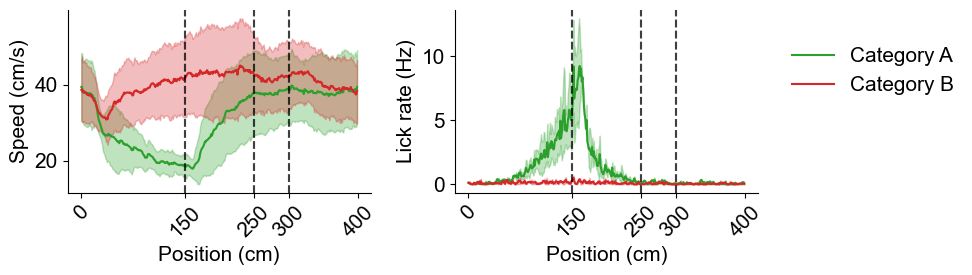

In [166]:
speed_cat = np.load("../data/notz/oneshot/overall/avg_speed_cat.npy")
lrate_cat = np.load("../data/notz/oneshot/overall/avg_lrate_cat.npy")
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_catvsbehav(speed_cat, "Speed (cm/s)", ax=ax[0])
plot_catvsbehav(lrate_cat, "Lick rate (Hz)", ax=ax[1], legend=True)
plt.tight_layout()

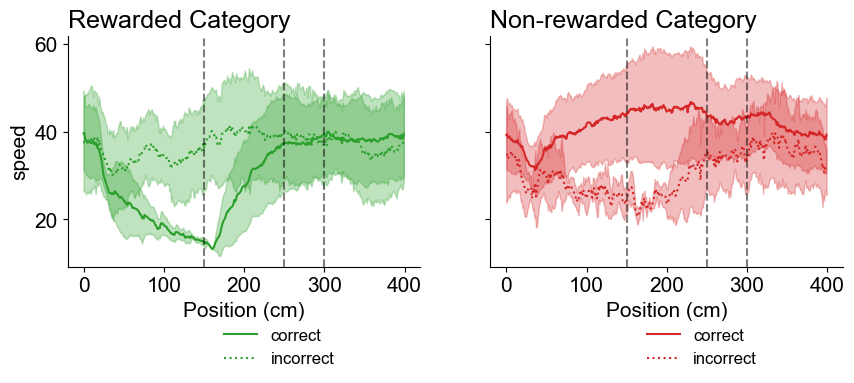

In [168]:
speed_cat = np.load("../data/notz/oneshot/overall/avg_speed_cat_lick.npy")
lrate_cat = np.load("../data/notz/oneshot/overall/avg_lrate_cat_lick.npy")
plot_behav_cov(speed_cat, 'speed', figsize=(10, 3))

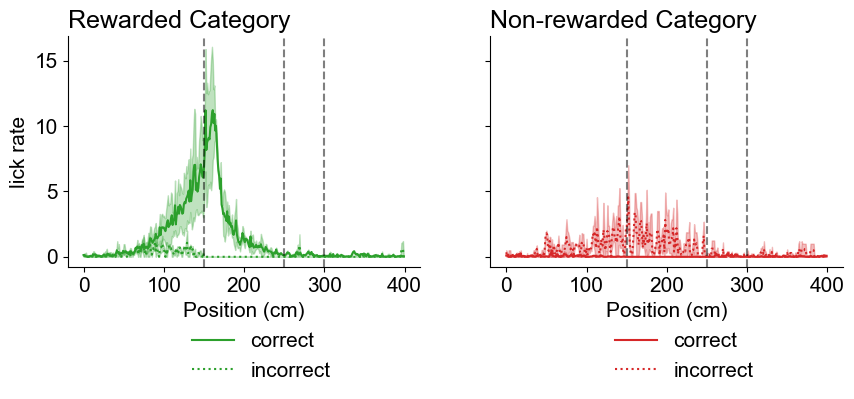

In [109]:
plot_behav_cov(lrate_cat, 'lick rate', figsize=(10, 3))